In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import json

from tiltmp.core.serialization import read_instance, decode_instance, write_instance
from tiltmp.mp.motionplanner import *
from tiltmp.mp.solution_data import SolutionData
from pandas import DataFrame
import re

from plot_util import *

In [2]:
%matplotlib inline

In [3]:
# global constants
FIG_SIZE = (19.20, 9.77)
FONTSCALE = 3
LEGENDSIZE = 30

SOLVER_HUE_ORDER = ["BFS", "GD", "GGD", "MMP", "MMPT", "DFP", "", "RRT"]

# Set result directories
I1_RESULTS = {
    "BFS": "results/bfs",
    "GD": "results/gd",
    "GGD": "results/ggd",
    "MMP": "results/mmp",
    "MMPT": "results/mmpt",
    "DFP": "results/dfp",
    "RRT": "results/rrt",
}

I2_RESULTS = {
    "GGD": "results/ggd_large",
    "MMPT": "results/mmpt_large",
    "DFP": "results/dfp_large",
}

I1_INSTANCES = "small_instances/"
I2_INSTANCES = "instances/"

OUT_PATH = "plots/"

matplotlib.rcParams['figure.figsize'] = FIG_SIZE

# use TrueType font instead of Type3 font
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
# define function for loading the solution and instance data
def load_data(paths: dict, regex=".*", instances=None):
    data = {}
    regex = re.compile(regex)
    for solver, file_or_directory in paths.items():
        solved_names = []
        dir_data = []
        if os.path.isdir(file_or_directory):
            for filename in os.listdir(file_or_directory):
                if not filename.endswith(".json"):
                    continue
                if not regex.match(filename):
                    continue
                solution = load_file(os.path.join(file_or_directory, filename))
                solved_names.append(filename.rsplit('_', 1)[0])
                if solution:
                    if "maze" in filename:
                        solution.board_type = "maze"
                    elif "cave" in filename:
                        solution.board_type = "cave"
                    solution.file_name = filename
                    dir_data.append(solution)
        elif os.path.isfile(file_or_directory):
            solution = load_file(file_or_directory)
            if solution:
                dir_data.append(solution)
        if dir_data:
            fixed_only = "dfp" in file_or_directory
            if instances and os.path.isdir(instances):
                dir_data += get_additional_instances(instances, regex, solved_names, fixed_only=fixed_only)
            for solution in dir_data:
                solution.solver = solver
            data[solver] = dir_data
    return data

# this may take some time and memory...
all_i1 = load_data(I1_RESULTS, instances=I1_INSTANCES)
all_i2 = load_data(I2_RESULTS, instances=I2_INSTANCES)

In [5]:
# Define some plotting functions
def get_consistent_solver_colors(data_frame: DataFrame, base_color_palette="muted"):
    used_hues = []
    color_palette = []
    full_palette = seaborn.color_palette(base_color_palette)
    for i, hue in enumerate(SOLVER_HUE_ORDER):
        if hue in data_frame["solver"].unique():
            used_hues += [hue]
            color_palette += [full_palette[i]]
    return color_palette, used_hues

def pair_plot(data, violin=False):
    d = {}
    for name, function in AXIS_FUNCTIONS.items():
        d[AXIS_LABELS[name]] = [function(instance) for instance in data]

    # set status depending on timeout or no timeout
    d["status"] = []
    for x in d["time[s]"]:
        d["status"].append("timed out" if x == float("inf") else "solved")

    data_frame = DataFrame(data=d)

    for key, values_list in data_frame.items():
        maximum = max(filter((float("inf")).__ne__, values_list))
        data_frame[key] = [maximum if x == float("inf") else x for x in values_list]

    # seaborn.pairplot(data_frame, dropna=True, hue="status", markers=["o", "X"], diag_kind="hist", hue_order=["solved", "timed out"])
    pairplot_stacked(data_frame, violin=violin)

def pairplot_stacked(df, violin=False):
    # below for the histograms on the diagonal

    g = seaborn.PairGrid(data=df, hue="status", hue_order=["solved", "timed out"])
    if violin:
        offdiag = seaborn.violinplot
        g.map_offdiag(offdiag, style=df["status"], markers={"solved": "o", "timed out": "X"}, cut=0, scale="count")
    else:
        offdiag = seaborn.scatterplot
        g.map_offdiag(offdiag, style=df["status"], markers={"solved": "o", "timed out": "X"})

    d = {}
    def func(x, **kwargs):
        ax = plt.gca()

        if not ax in d.keys():
            d[ax] = {"data": [], "color": []}
        d[ax]["data"].append(x)
        d[ax]["color"].append(kwargs.get("color"))

    g.map_diag(func)
    for ax, dic in d.items():
        ax.hist(dic["data"], color=dic["color"], histtype="barstacked")


def plot_steps_to_goal(solution_data_sets: dict, x_axis=None, average=True):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    for data_set in solution_data_sets:
        data_set = [i for i in data_set if number_of_tiles(i) == target_shape_size(i)]
        d = {}
        d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
        if x_axis is not None:
            x_function = AXIS_FUNCTIONS[x_axis]
            x_axis_label = AXIS_LABELS[x_axis]
            d[x_axis_label] = [x_function(instance) for instance in data_set]
            if x_axis == "size":
                d[x_axis_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[x_axis_label]]
        d["solver"] = [instance.solver for instance in data_set]
        d["steps to target"] = [steps_to_goal(instance) for instance in data_set]
        data_frame = data_frame.append(DataFrame(data=d))

    palette, hue_order = get_consistent_solver_colors(data_frame)

    dropped_nan = data_frame[data_frame["steps to target"].notnull()]
    seaborn.boxplot(x=None if x_axis is None else AXIS_LABELS[x_axis], y="steps to target", data=dropped_nan,
                    hue="solver", hue_order=hue_order, flierprops=dict(markerfacecolor='0.50', markersize=5),
                    palette=palette, showmeans=average,
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"})
    plt.legend(loc="upper left", prop={'size': LEGENDSIZE})
    plt.show()



def plot_maze_vs_cave(data_set, label, x_axis, y_axis, outliers=False, average=False):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    x_function = AXIS_FUNCTIONS[x_axis]
    x_axis_label = AXIS_LABELS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    y_axis_label = AXIS_LABELS[y_axis]

    d = {}
    d[x_axis_label] = [x_function(instance) for instance in data_set]
    if x_axis == "size":
        d[x_axis_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[x_axis_label]]
    d[y_axis_label] = [y_function(instance) for instance in data_set]
    d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
    d["board type"] = [instance.board_type + " (" + label + ")" for instance in data_set]
    d["solver"] = [label] * len(d[x_axis_label])

    data_frame = data_frame.append(DataFrame(data=d))

    terminated = data_frame[data_frame["status"] == "terminated"]

    hue_order = ["cave" " (" + label + ")", "maze" " (" + label + ")"]

    if y_axis_label == "solution length":
        solved = data_frame[data_frame["solution length"] != float("inf")]
        solved = solved[solved["solution length"] != 0]
        # seaborn.violinplot(x=x_axis_label, y=y_axis_label, data=solved, hue="solver", hue_order=hue_order
        #                   , palette=palette, scale="width", cut=0, dropna=True)
        seaborn.boxplot(x=x_axis_label, y=y_axis_label, data=solved, hue="board type", hue_order=hue_order,
                        palette="muted", flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average,
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"})
        plt.legend(loc="upper left", prop={'size': LEGENDSIZE})
    else:
        #seaborn.violinplot(x=x_axis_label, y=y_axis_label, data=terminated, hue="solver", hue_order=hue_order,x
        #                palette=palette, scale="width", cut = 0)
        seaborn.boxplot(x=x_axis_label, y=y_axis_label, data=terminated, hue="board type",
                        palette="muted", flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average,
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"})
        plt.legend(loc="upper left", prop={'size': LEGENDSIZE})
        plt.axhline(y=600, color="r", linestyle="dotted")

    plt.show()

    def fraction_solved(x):
        return x[x.str.contains("terminated")].count() / len(x)

    solved_counts = data_frame.groupby(["board type", x_axis_label])["status"].apply(fraction_solved)\
        .to_frame(name="fraction of instances").reset_index()

    seaborn.catplot(
        data=solved_counts, kind="bar",
        x=x_axis_label, y="fraction of instances", hue="board type",
        ci="sd", palette="muted", hue_order=hue_order, legend_out=False
    )

    plt.legend(loc="upper right", prop={'size': LEGENDSIZE})

    plt.show()


def plot_number_of_glues(data_set, label, x_axis, y_axis, outliers=False, average=False):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    title = "glue types" + " (" + label + ")"

    x_function = AXIS_FUNCTIONS[x_axis]
    x_axis_label = AXIS_LABELS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    y_axis_label = AXIS_LABELS[y_axis]

    d = {}
    d[x_axis_label] = [x_function(instance) for instance in data_set]
    if x_axis == "size":
        d[x_axis_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[x_axis_label]]
    d[y_axis_label] = [y_function(instance) for instance in data_set]
    d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
    d["glue types"] = [glue_types(instance) for instance in data_set]
    d["solver"] = [label] * len(d[x_axis_label])

    data_frame = data_frame.append(DataFrame(data=d))

    terminated = data_frame[data_frame["status"] == "terminated"]

    hue_order = list(sorted(set(d["glue types"])))

    if y_axis_label == "solution length":
        solved = data_frame[data_frame["solution length"] != float("inf")]
        solved = solved[solved["solution length"] != 0]
        # seaborn.violinplot(x=x_axis_label, y=y_axis_label, data=solved, hue="solver", hue_order=hue_order
        #                   , palette=palette, scale="width", cut=0, dropna=True)
        seaborn.boxplot(x=x_axis_label, y=y_axis_label, data=solved, hue="glue types", hue_order=hue_order,
                        palette="muted", flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average,
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"})
        plt.legend(loc="upper left", prop={'size': LEGENDSIZE}, title=title)
    else:
        #seaborn.violinplot(x=x_axis_label, y=y_axis_label, data=terminated, hue="solver", hue_order=hue_order,x
        #                palette=palette, scale="width", cut = 0)
        seaborn.boxplot(x="glue types", y=y_axis_label, data=terminated, #hue="glue types",
                        palette="muted", flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average,
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"})
        plt.legend(loc="upper left", prop={'size': LEGENDSIZE}, title=title)
        #plt.axhline(y=600, color="r", linestyle="dotted")

    plt.show()


    def fraction_solved(x):
        return x[x.str.contains("terminated")].count() / len(x)

    solved_counts = data_frame.groupby(["glue types"])["status"].apply(fraction_solved)\
        .to_frame(name="fraction of instances").reset_index()

    seaborn.catplot(
        data=solved_counts, kind="bar",
        x="glue types", y="fraction of instances", #hue="glue types",
        ci="sd", palette="muted", legend_out=False
    )

    plt.legend(loc="upper right", prop={'size': LEGENDSIZE}, title=title, framealpha=0.5)

    plt.show()


def plot_fixed_vs_not_fixed(data_set, label, x_axis, y_axis, outliers=False, average=True):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    title = "problem type " + "(" + label + ")"

    x_function = AXIS_FUNCTIONS[x_axis]
    x_axis_label = AXIS_LABELS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    y_axis_label = AXIS_LABELS[y_axis]

    d = {}
    d[x_axis_label] = [x_function(instance) for instance in data_set]
    if x_axis == "size":
        d[x_axis_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[x_axis_label]]
    d[y_axis_label] = [y_function(instance) for instance in data_set]
    d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
    d["fixed"] = ["with seed tile" if is_fixed(instance) else "without seed tile" for instance in data_set]
    d["solver"] = [label] * len(d[x_axis_label])

    data_frame = data_frame.append(DataFrame(data=d))

    if y_axis_label == "solution length":
        data = data_frame[data_frame["solution length"] != float("inf")]
        data = data[data["solution length"] != 0]
    else:
        data = data_frame[data_frame["status"] == "terminated"]

    hue_order = ["with seed tile", "without seed tile"]

    fig1 = plt.figure()
    plt.subplots_adjust(wspace=0.015, left=0.075, right=1, top=1)

    seaborn.boxplot(x=x_axis_label, y=y_axis_label, data=data, hue="fixed", hue_order=hue_order,
                    palette="Set3", flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average,
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"})
    plt.legend(loc="upper left", prop={'size': LEGENDSIZE}, title=title)

    fig2 = plt.figure()
    plt.subplots_adjust(wspace=0.015, left=0.075, right=1, top=1)
    def fraction_solved(x):
        return x[x.str.contains("terminated")].count() / len(x)

    solved_counts = data_frame.groupby(["fixed", x_axis_label])["status"].apply(fraction_solved) \
        .to_frame(name="fraction of instances").reset_index()

    seaborn.barplot(
        data=solved_counts,
        x=x_axis_label, y="fraction of instances", hue="fixed",
        ci="sd", palette="Set3", hue_order=hue_order,
    )

    plt.legend(loc="upper right", prop={'size': LEGENDSIZE}, title="", ncol=5, columnspacing=0.5)
    plt.gca().set(ylim=(0, 0.9999))

    #frac_plot.legend_.remove()
    #frac_plot.legend(loc="upper right", prop={'size': LEGENDSIZE}, ncol=5, columnspacing=0.5)
    return fig1, fig2

def plot_multi_peak_memory(data_sets):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    x_axis = "time"
    y_axis = "mem"

    x_function = AXIS_FUNCTIONS[x_axis]
    x_axis_label = AXIS_LABELS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    y_axis_label = AXIS_LABELS[y_axis]

    for data_set in data_sets:
        d = {}
        data_set = [i for i in data_set if hasattr(i, "max_mem_usage")]

        d[x_axis_label] = [x_function(instance) for instance in data_set]
        if x_axis == "size":
            d[x_axis_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[x_axis_label]]
        d[y_axis_label] = [y_function(instance) for instance in data_set]
        d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
        d["fixed"] = ["seed tile" if is_fixed(instance) else "no seed tile" for instance in data_set]
        d["solver"] = [instance.solver for instance in data_set]
        data_frame = data_frame.append(DataFrame(data=d))

    palette, hue_order = get_consistent_solver_colors(data_frame, base_color_palette="tab10")
    plt.subplots_adjust(wspace=0.015, left=0.075, right=1, top=1)

    seaborn.scatterplot(x=x_axis_label, y=y_axis_label, data=data_frame,
                        markers=("o","s","X"),
                        s=350, palette=palette,
                        hue_order=hue_order, hue="solver", style="solver")
    plt.legend(loc="upper left", markerscale=3, prop={'size': LEGENDSIZE})
    # Modify the point edge colour
    for ha in plt.gca().legend_.legendHandles:
        ha.set_edgecolor("white")
        ha.set_linewidth(2)
    # plt.axvline(x=600, color="r", linestyle="dotted")
    plt.show()

def plot_peak_memory(data_set, label):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    x_axis = "time"
    y_axis = "mem"

    x_function = AXIS_FUNCTIONS[x_axis]
    x_axis_label = AXIS_LABELS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    y_axis_label = AXIS_LABELS[y_axis]

    data_set = [i for i in data_set if hasattr(i, "max_mem_usage")]
    d = {}
    d[x_axis_label] = [x_function(instance) for instance in data_set]
    if x_axis == "size":
        d[x_axis_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[x_axis_label]]
    d[y_axis_label] = [y_function(instance) for instance in data_set]
    d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
    d["fixed"] = ["seed tile" if is_fixed(instance) else "no seed tile" for instance in data_set]
    d["solver"] = [label] * len(d[x_axis_label])

    data_frame = data_frame.append(DataFrame(data=d))

    palette, hue_order = get_consistent_solver_colors(data_frame, base_color_palette="tab10")

    seaborn.scatterplot(x=x_axis_label, y=y_axis_label, data=data_frame, marker="o", s=175, palette=palette, hue_order=hue_order, hue="solver")
    plt.legend(loc="upper left", prop={'size': LEGENDSIZE})
    #plt.axvline(x=600, color="r", linestyle="dotted")
    plt.show()


def plot_extra_tiles(solution_data_sets, x_axis, y_axis, outliers=False, average=True):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    x_function = AXIS_FUNCTIONS[x_axis]
    x_axis_label = AXIS_LABELS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    y_axis_label = AXIS_LABELS[y_axis]


    for data_set in solution_data_sets:
        data_set = [i for i in data_set if target_shape_size(i)==10]
        d = {}
        d[x_axis_label] = [x_function(instance) for instance in data_set]
        if x_axis == "size":
            d[x_axis_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[x_axis_label]]
        d[y_axis_label] = [y_function(instance) for instance in data_set]
        d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
        d["solver"] = [instance.solver for instance in data_set]
        d["extra tiles"] = [number_of_tiles(instance) - target_shape_size(instance) for instance in data_set]
        data_frame = data_frame.append(DataFrame(data=d))

    if y_axis_label == "solution length":
        data = data_frame[data_frame["solution length"] != float("inf")]
        data = data[data["solution length"] != 0]
    else:
        data = data_frame[data_frame["status"] == "terminated"]

    palette, hue_order = get_consistent_solver_colors(data)

    seaborn.boxplot(x="extra tiles", y=y_axis_label, data=data, hue="solver", hue_order=hue_order,
                    palette=palette, flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average,
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"})
    if y_axis_label == "time[s]":
        pass
        plt.axhline(y=600, color="r", linestyle="dotted")
    plt.legend(loc="upper left", prop={'size': LEGENDSIZE})

    plt.show()

    def fraction_solved(x):
        return x[x.str.contains("terminated")].count() / len(x)

    solved_counts = data_frame.groupby(["solver", "extra tiles"])["status"].apply(fraction_solved) \
        .to_frame(name="fraction of instances").reset_index()

    seaborn.catplot(
        data=solved_counts, kind="bar",
        x="extra tiles", y="fraction of instances", hue="solver",
        ci="sd", palette=palette, hue_order=hue_order, legend_out=False
    )

    plt.legend(loc="upper left", prop={'size': LEGENDSIZE})

    plt.show()


def plot_size_and_tiles_combined(
        solution_data_sets, y_axis, outliers=False, average=True, boxplot_max=None,fraction_solved_min=None,
        fraction_solved_max=None, target_size_or_tiles="tiles", save_as=("plt1.pdf", "plt2.pdf")):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    tiles_function = AXIS_FUNCTIONS[target_size_or_tiles]
    tiles_label = AXIS_LABELS[target_size_or_tiles]
    size_function = AXIS_FUNCTIONS["size"]
    size_label = AXIS_LABELS["size"]
    y_function = AXIS_FUNCTIONS[y_axis]
    y_axis_label = AXIS_LABELS[y_axis]

    for data_set in solution_data_sets:
        d = {}
        d[tiles_label] = [tiles_function(instance) for instance in data_set]
        d[size_label] = [size_function(instance) for instance in data_set]
        d[size_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[size_label]]

        d[y_axis_label] = [y_function(instance) for instance in data_set]

        d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
        d["solver"] = [instance.solver for instance in data_set]

        data_frame = data_frame.append(DataFrame(data=d))

    if y_axis_label == "solution length":
        data = data_frame[data_frame["solution length"] != float("inf")]
        data = data[data["solution length"] != 0]
    else:
        data = data_frame[data_frame["status"] == "terminated"]

    palette, hue_order = get_consistent_solver_colors(data)

    fig1, axs = plt.subplots(ncols=2)
    plt.subplots_adjust(wspace=0.015, left=0.075, right=1, top=1)
    tiles_plot = seaborn.boxplot(x=tiles_label, y=y_axis_label, data=data, hue="solver", hue_order=hue_order,
                    palette=palette, flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average,
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"},
                    ax=axs[0]
                    )
    size_plot = seaborn.boxplot(x=size_label, y=y_axis_label, data=data, hue="solver", hue_order=hue_order,
                    palette=palette, flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average, order=sorted(set(data[size_label]), key=lambda s: int(s.split("x")[0])),
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"},
                    ax=axs[1]
                    )

    size_plot.set(ylabel=None)
    size_plot.set(yticklabels=[])

    if y_axis_label == "time[s]":
        pass
        tiles_plot.axhline(y=600, color="r", linestyle="dotted")
        size_plot.axhline(y=600, color="r", linestyle="dotted")
    tiles_plot.legend_.remove()
    size_plot.legend(loc="upper right", prop={'size': LEGENDSIZE})

    y_max = boxplot_max or max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
    tiles_plot.set(ylim=(0, y_max))
    size_plot.set(ylim=(0, y_max))

    def fraction_solved(x):
        return x[x.str.contains("terminated")].count() / len(x)

    solved_counts_tiles = data_frame.groupby(["solver", tiles_label])["status"].apply(fraction_solved) \
        .to_frame(name="fraction of instances").reset_index()

    solved_counts_size = data_frame.groupby(["solver", size_label])["status"].apply(fraction_solved) \
        .to_frame(name="fraction of instances").reset_index()

    fig2, axs = plt.subplots(ncols=2)
    plt.subplots_adjust(wspace=0.015, left=0.075, right=1, top=1)

    tiles_solved_plot = seaborn.barplot(
        data=solved_counts_tiles,
        x=tiles_label, y="fraction of instances", hue="solver",
        ci="sd", palette=palette, hue_order=hue_order,
        ax=axs[0]
    )
    size_solved_plot = seaborn.barplot(
        data=solved_counts_size,
        x=size_label, y="fraction of instances", hue="solver",
        ci="sd", palette=palette, hue_order=hue_order,
        order=sorted(set(data[size_label]), key=lambda s: int(s.split("x")[0])),
        ax=axs[1]
    )

    size_solved_plot.set(ylabel=None)
    size_solved_plot.set(yticklabels=[])

    tiles_solved_plot.legend_.remove()
    size_solved_plot.legend(loc="upper right", prop={'size': LEGENDSIZE}, ncol=5, columnspacing=0.5)


    y_max = fraction_solved_max or max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
    y_min = fraction_solved_min or 0

    tiles_solved_plot.set(ylim=(y_min, y_max))
    size_solved_plot.set(ylim=(y_min, y_max))

    return fig1, fig2

def plot_box_plot_grouped_by_solver(solution_data_sets, x_axis, y_axis, outliers=False, average=False):
    seaborn.set(font_scale=FONTSCALE)
    data_frame = DataFrame()

    x_function = AXIS_FUNCTIONS[x_axis]
    x_axis_label = AXIS_LABELS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    y_axis_label = AXIS_LABELS[y_axis]

    for data_set in solution_data_sets:
        d = {}
        d[x_axis_label] = [x_function(instance) for instance in data_set]
        if x_axis == "size":
            d[x_axis_label] = [str(int(math.sqrt(size))) + "x" + str(int(math.sqrt(size))) for size in d[x_axis_label]]
        d[y_axis_label] = [y_function(instance) for instance in data_set]
        d["status"] = ["timed out" if instance.timed_out else "terminated" for instance in data_set]
        d["solver"] = [instance.solver for instance in data_set]

        data_frame = data_frame.append(DataFrame(data=d))


    if y_axis_label == "solution length":
        data = data_frame[data_frame["solution length"] != float("inf")]
        data = data[data["solution length"] != 0]

    else:
        data = data_frame[data_frame["status"] == "terminated"]

    palette, hue_order = get_consistent_solver_colors(data)

    seaborn.boxplot(x=x_axis_label, y=y_axis_label, data=data, hue="solver", hue_order=hue_order,
                    palette=palette, flierprops=dict(markerfacecolor='0.50', markersize=5), showfliers=outliers,
                    showmeans=average,
                    order=sorted(set(data[x_axis_label]), key=lambda s: int(s.split("x")[0])),
                    meanprops={"marker": "o",
                               "markerfacecolor": "white",
                               "markeredgecolor": "black",
                               "markersize": "10"})
    if y_axis_label == "time[s]":
        pass
        plt.axhline(y=600, color="r", linestyle="dotted")
    plt.legend(loc="upper left", prop={'size': LEGENDSIZE})
    plt.show()

    def fraction_solved(x):
        return x[x.str.contains("terminated")].count() / len(x)

    solved_counts = data_frame.groupby(["solver", x_axis_label])["status"].apply(fraction_solved)\
        .to_frame(name="fraction of instances").reset_index()

    seaborn.catplot(
        data=solved_counts, kind="bar",
        x=x_axis_label, y="fraction of instances", hue="solver",
        ci="sd", palette=palette, hue_order=hue_order, legend_out=False,
        order=sorted(set(data[x_axis_label]), key=lambda s: int(s.split("x")[0]))
    )
    #plt.ylim(0, 1.0)
    plt.legend("", loc="upper right", prop={'size': 0}, framealpha=0.0)

    plt.show()


def plot_bars(data, x_axis):
    d = {}
    for instance in data:
        x = AXIS_FUNCTIONS[x_axis](instance)
        if x not in d.keys():
            d[x] = (0, 0)
        if instance.timed_out:
            d[x] = (d[x][0], d[x][1] + 1)
        else:
            d[x] = (d[x][0] + 1, d[x][1])

    labels = list(sorted(d.keys()))

    terminated = []
    timed_out = []

    for label in labels:
        total = d[label][0] + d[label][1]
        terminated += [d[label][0] / total]
        timed_out += [d[label][1] / total]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    # rects1 = ax.bar(x, terminated, width, label='terminated')
    rects2 = ax.bar(x, timed_out, width, label='timed out')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Fraction of instances", fontsize=18)
    #ax.set_title("Fraction timed_out instances by " + AXIS_LABELS[x_axis])

    ax.set_xticks(x, labels)
    ax.legend()

    #def autolabel(rects):
    #    for rect in rects:
    #        height = rect.get_height()
    #        ax.annotate('{}'.format(height),
    #                    xy=(rect.get_x() + rect.get_width() / 2, height),
    #                    xytext=(0, 3),  # 3 points vertical offset
    #                    textcoords="offset points",
    #                    ha='center', va='bottom')

    #autolabel(rects1)
    #autolabel(rects2)

    fig.tight_layout()
    plt.show()

def plot_violin(data, x_axis, y_axis):
    x_function = AXIS_FUNCTIONS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    x = [x_function(instance) for instance in data]
    y = [y_function(instance) for instance in data]

    data = defaultdict(list)
    for i in range(len(x)):
        if y[i] != float("inf"):
            data[x[i]] += [y[i]]

    x_values = []
    sorted_data = []
    for x_value in sorted(data.keys()):
        x_values += [x_value]
        sorted_data.append(data[x_value])

    plt.violinplot(sorted_data, x_values)
    plt.xlabel(AXIS_LABELS[x_axis])
    plt.ylabel(AXIS_LABELS[y_axis])

def plot(data, x_axis, y_axis):
    x_function = AXIS_FUNCTIONS[x_axis]
    y_function = AXIS_FUNCTIONS[y_axis]
    x = [x_function(instance) for instance in data]
    y = [y_function(instance) for instance in data]

    plt.scatter(x, y, marker='.')
    plt.xlabel(AXIS_LABELS[x_axis])
    plt.ylabel(AXIS_LABELS[y_axis])

    # represent float("inf") values with x at the edges of the plot
    _, max_x = plt.gca().get_xlim()
    _, max_y = plt.gca().get_ylim()

    highx = [(max_x, b) for a, b in zip(x, y) if a == float("inf")]
    highy = [(a, max_y) for a, b in zip(x, y) if b == float("inf")]
    points = highx + highy

    x = [a for a, _ in points]
    y = [b for _, b in points]

    plt.scatter(x, y, marker='x', alpha=0.3)


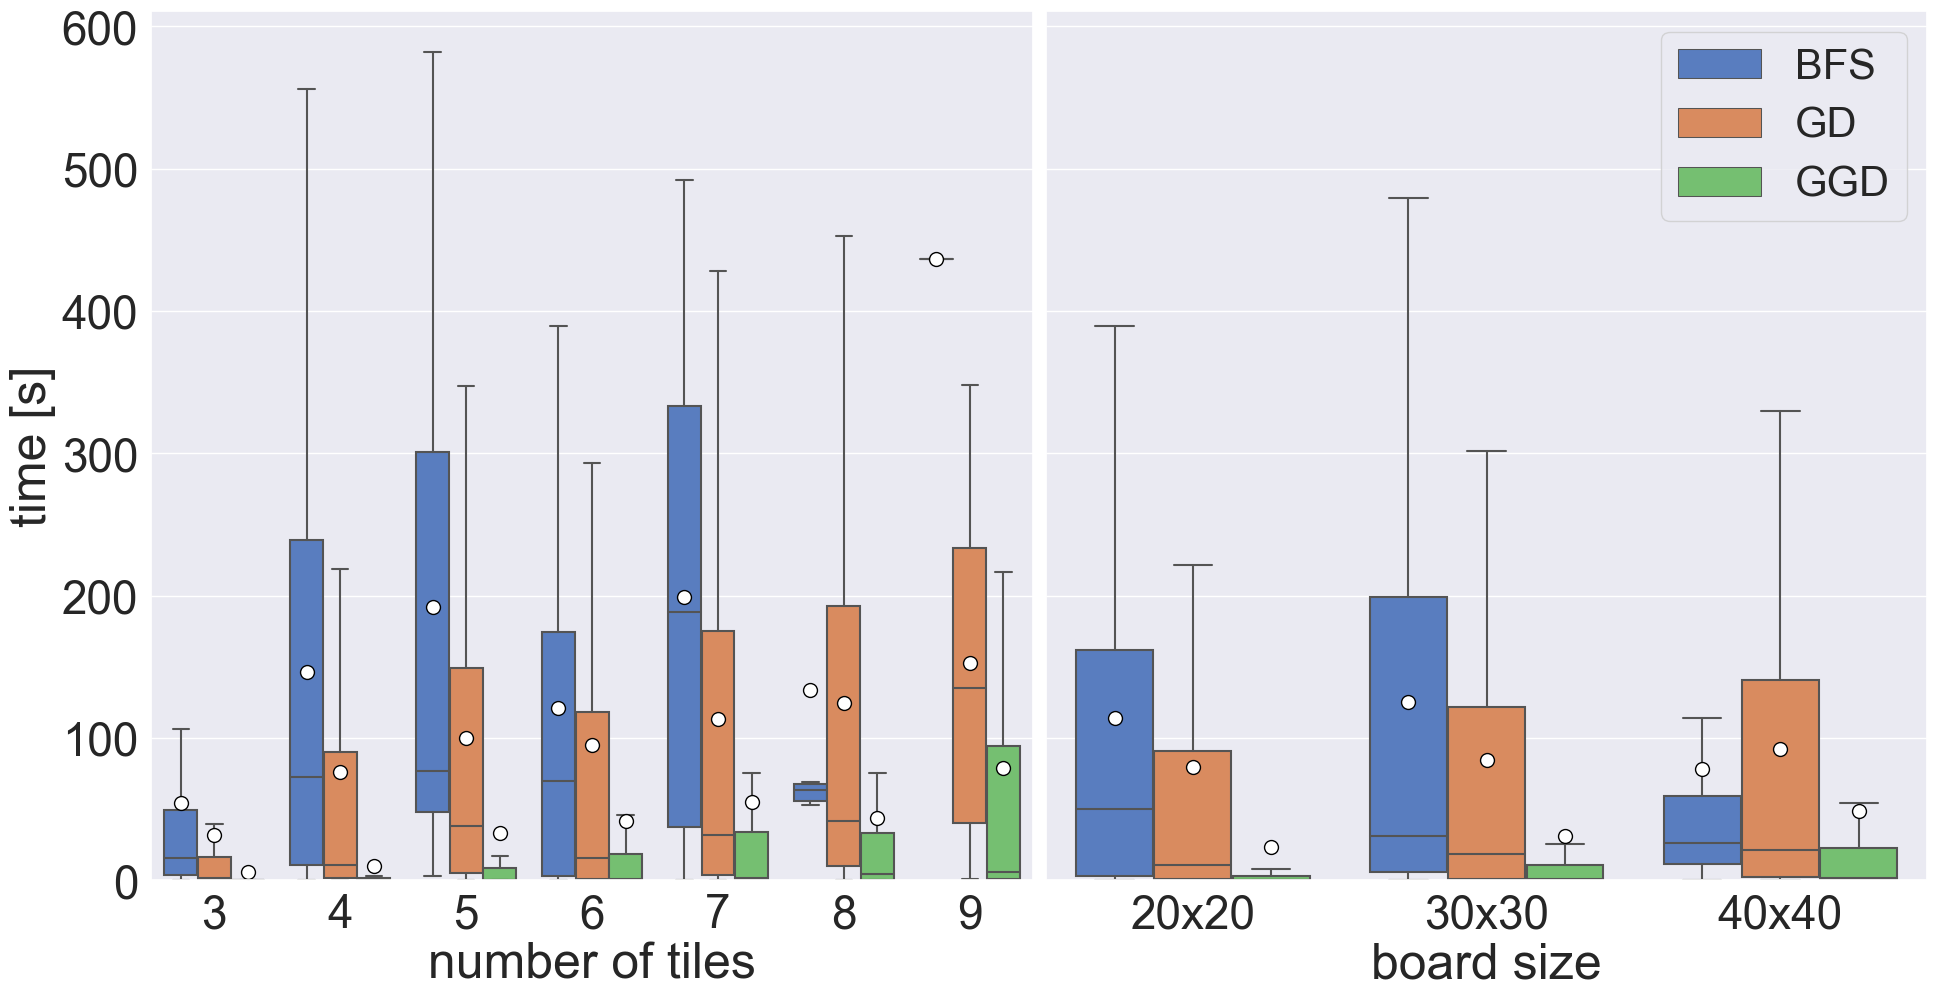

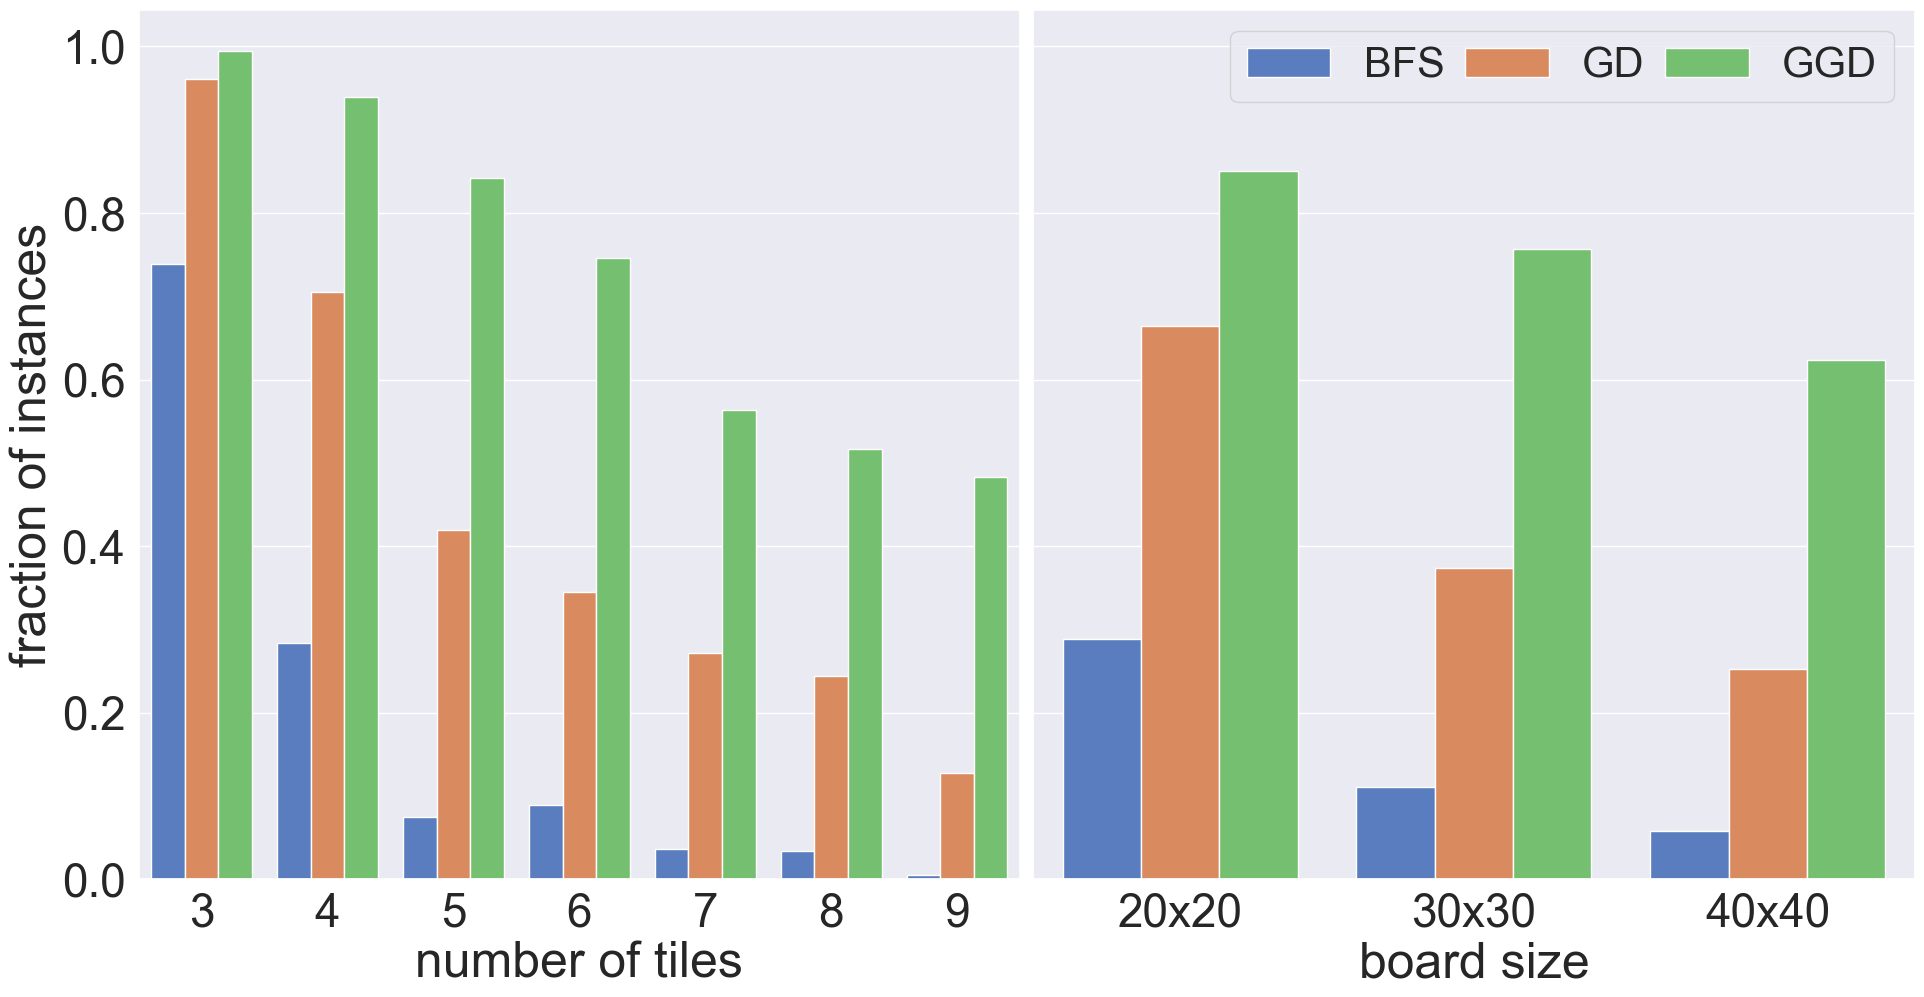

In [6]:
# performance comparison of simple heuristics on small instances
data = [all_i1[solver] for solver in ("BFS", "GD", "GGD")]
f1, f2 = plot_size_and_tiles_combined(data, y_axis="time")
f1.savefig("plots/best_first_runtime.pdf", format="pdf", dpi=100)
f2.savefig("plots/best_first_fraction_solved.pdf", format="pdf", dpi=100)

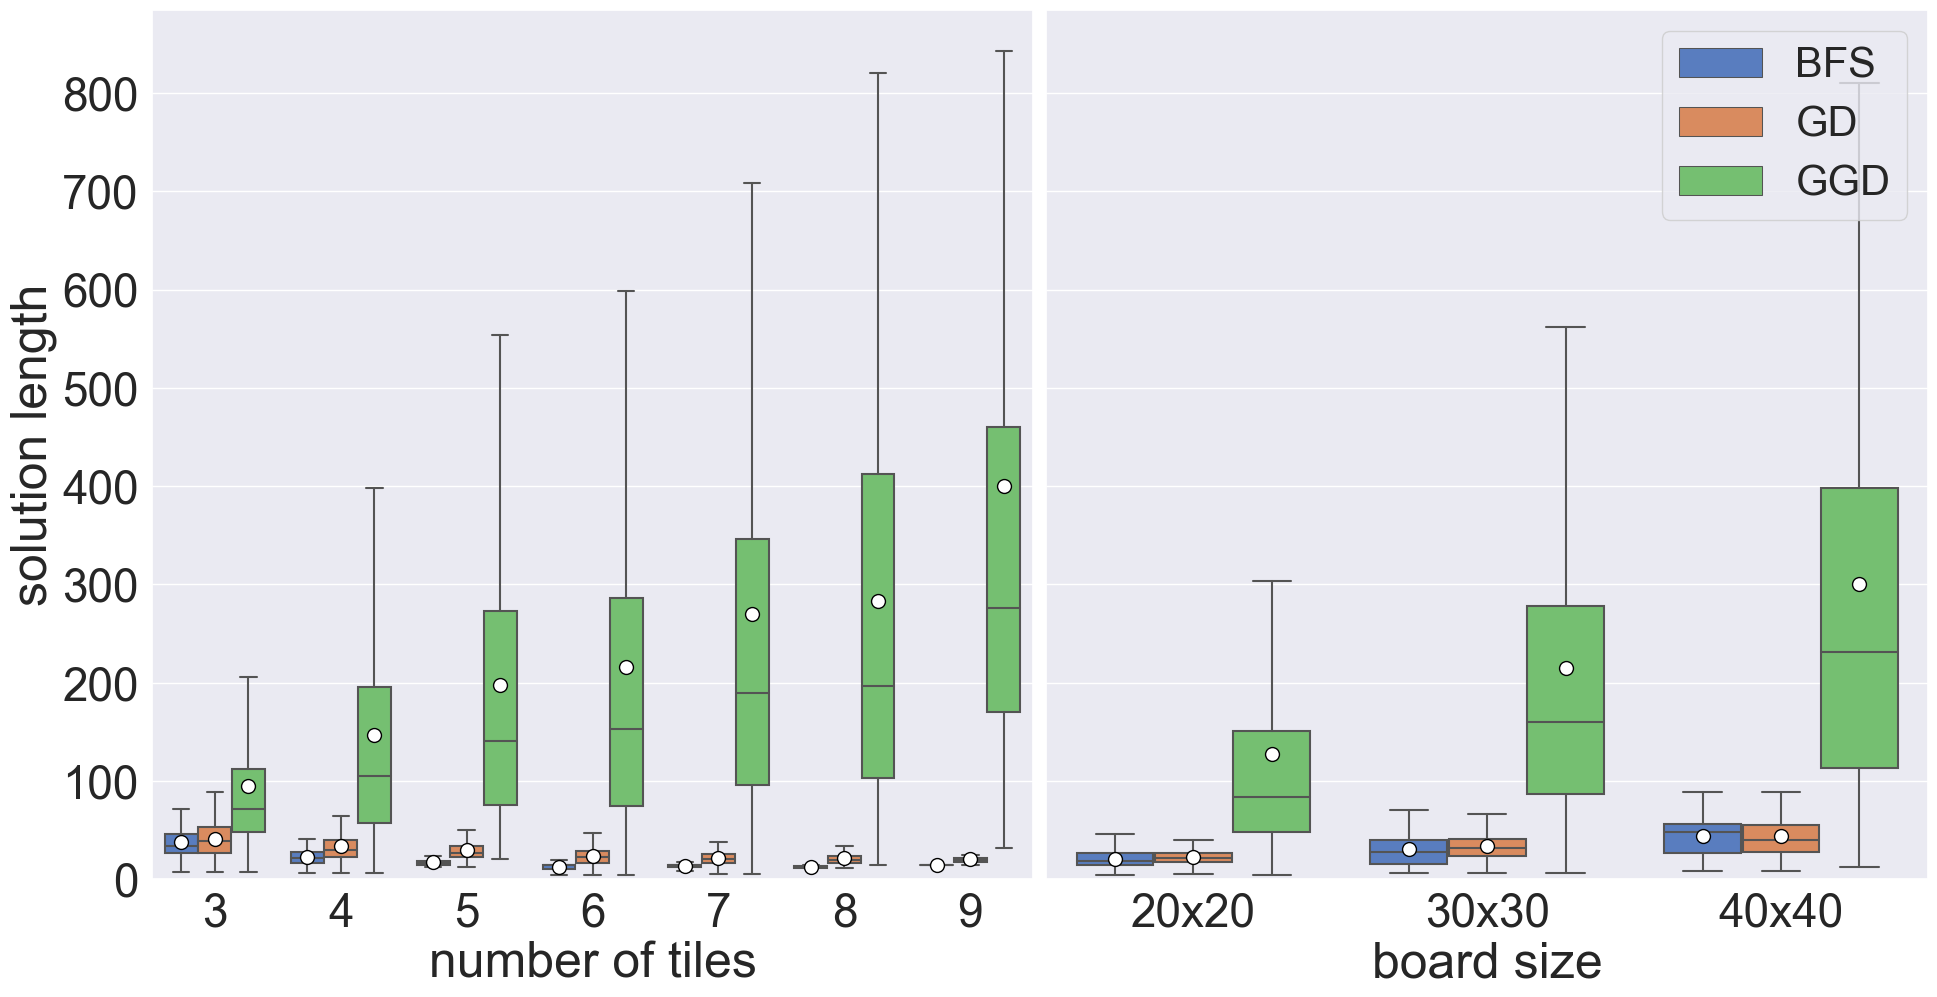

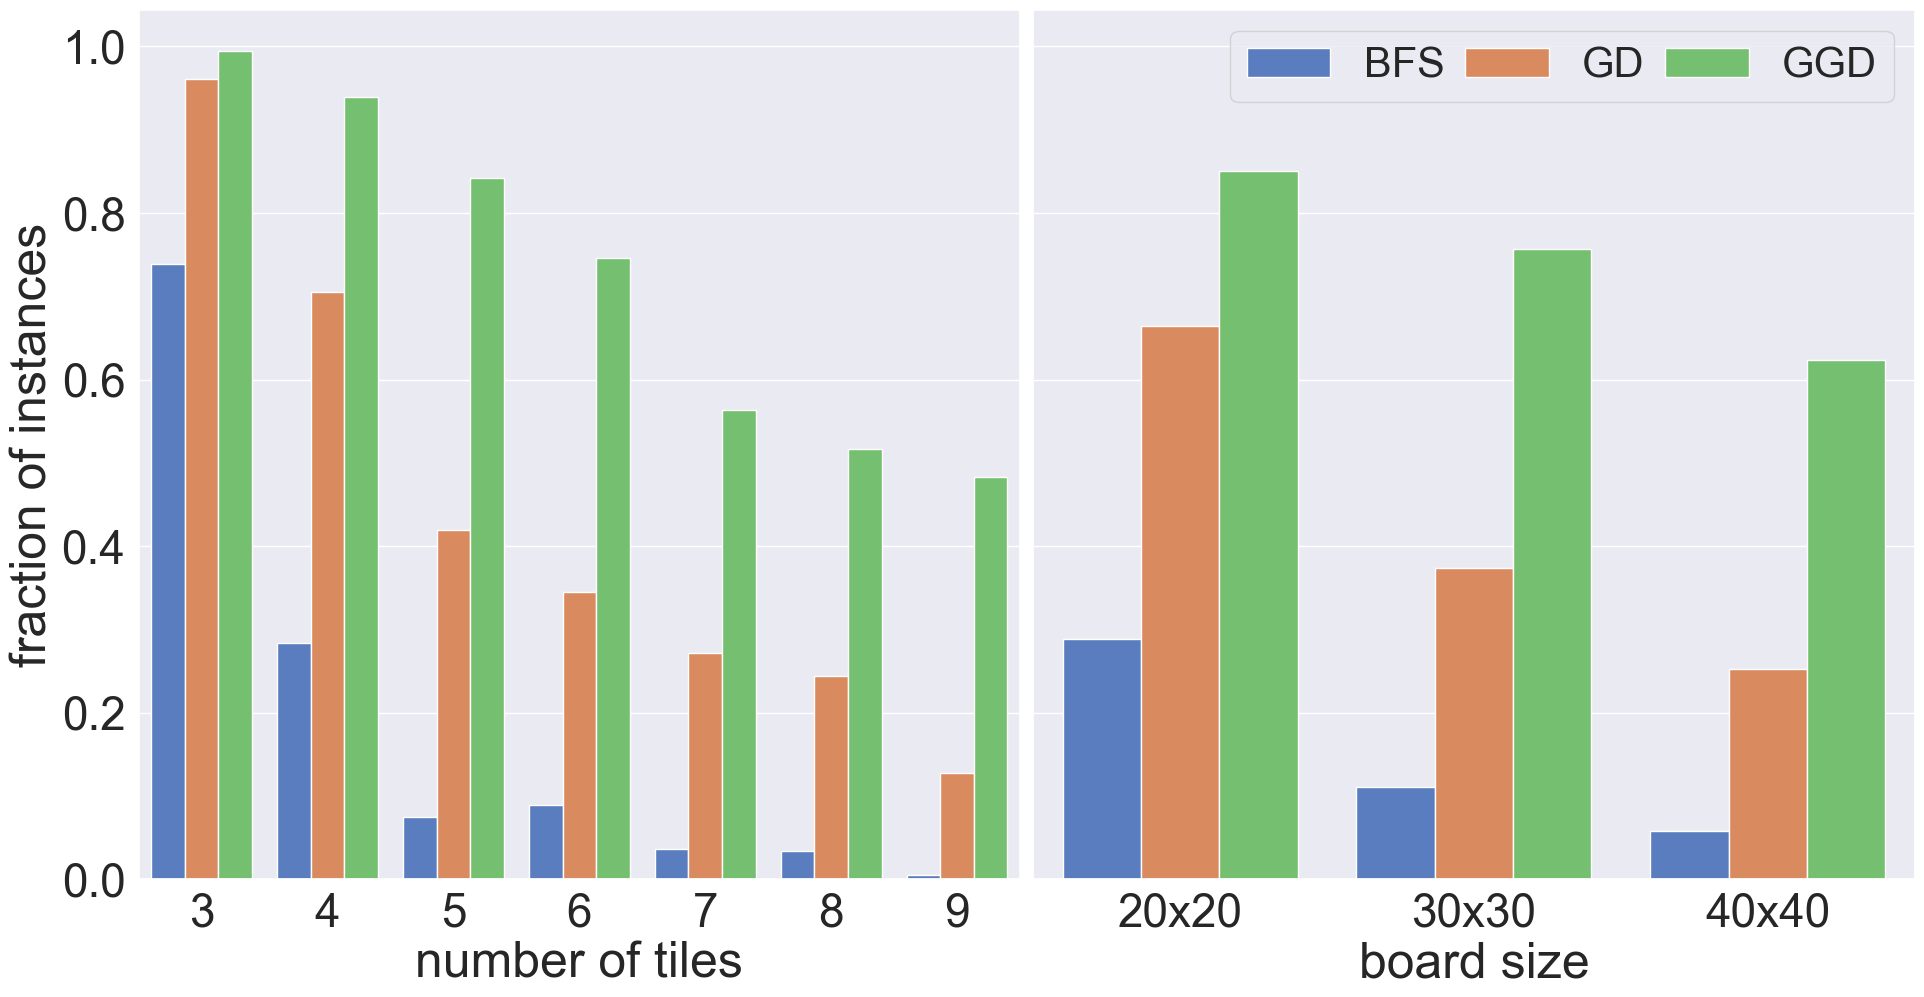

In [7]:
# solution length comparison of simple heuristics on small instances
data = [all_i1[solver] for solver in ("BFS", "GD", "GGD")]
f1, _ = plot_size_and_tiles_combined(data, y_axis="solution_length")
f1.savefig("plots/best_first_solution_length.pdf", format="pdf", dpi=100)

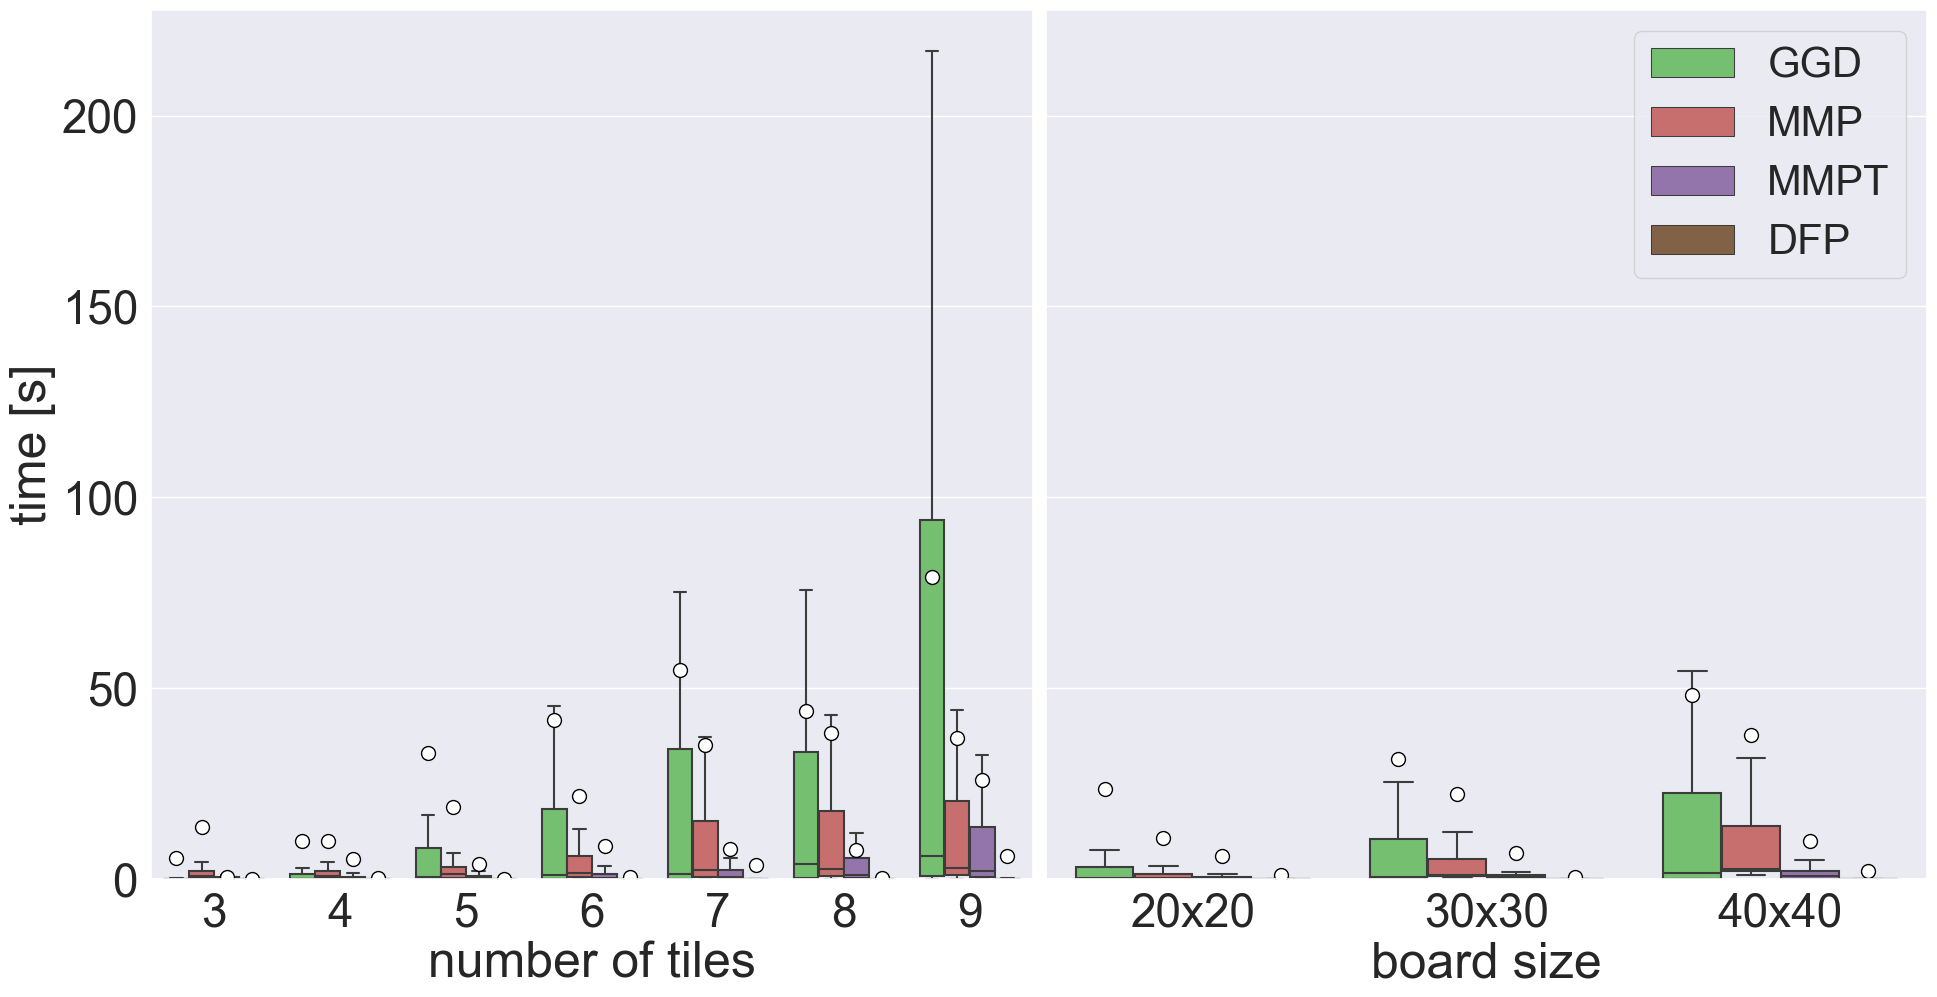

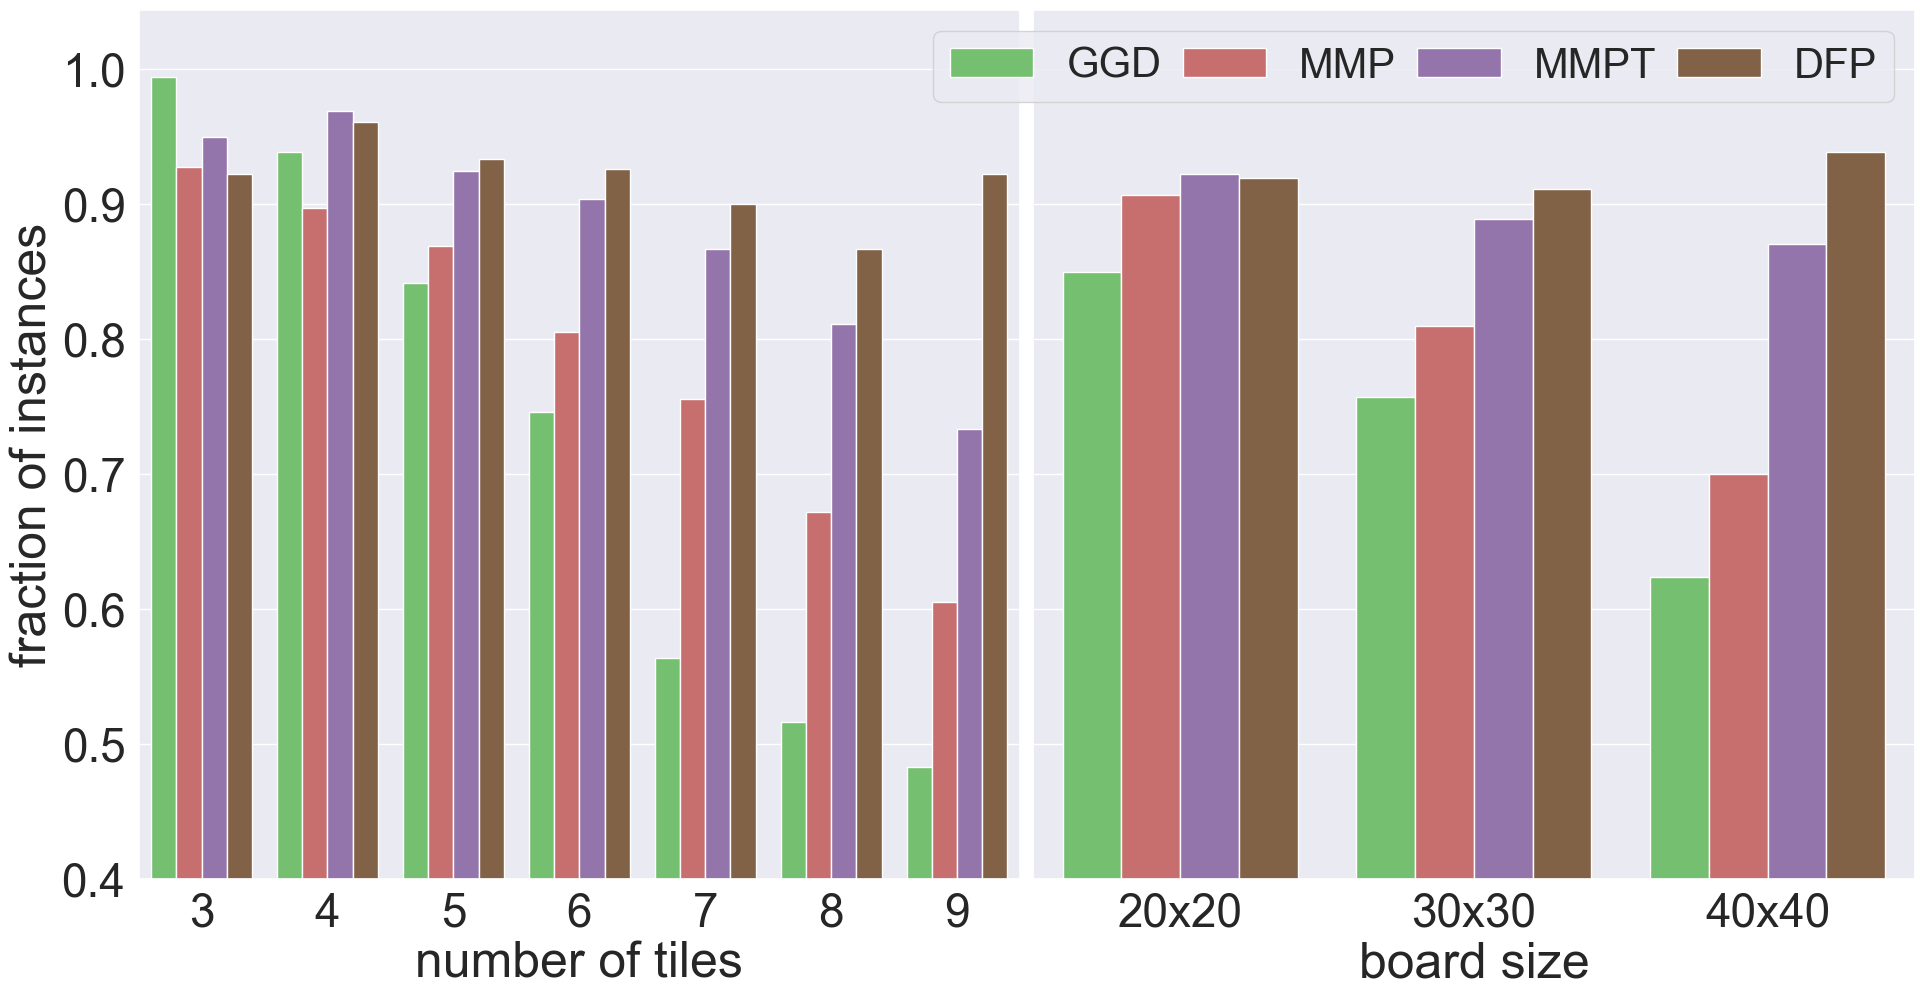

In [8]:
# performance comparison of multiple solvers on small instances
data = [all_i1[solver] for solver in ("GGD", "MMP", "MMPT", "DFP")]
f1, f2 = plot_size_and_tiles_combined(data, y_axis="time", fraction_solved_min=0.4,)
f1.savefig("plots/i1_runtime_without_rrt.pdf", format="pdf", dpi=100)
f2.savefig("plots/i1_fraction_solved_without_rrt.pdf", format="pdf", dpi=100)

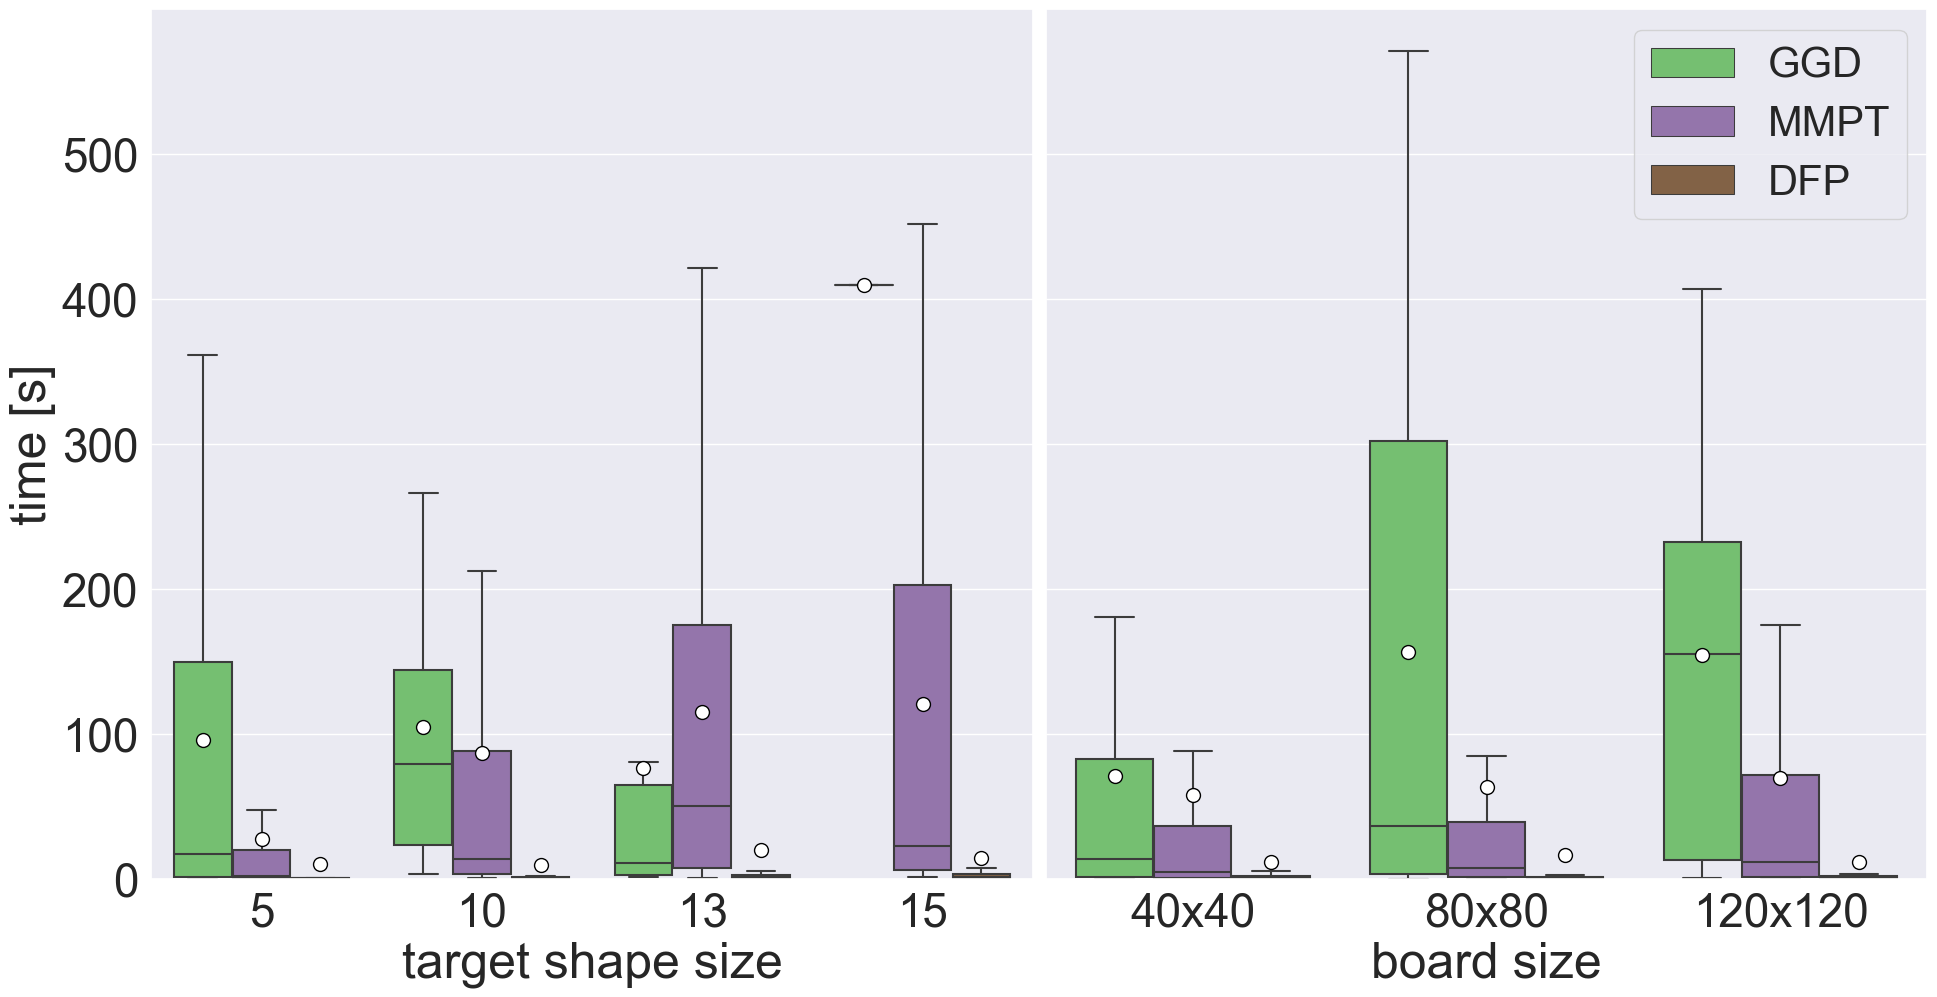

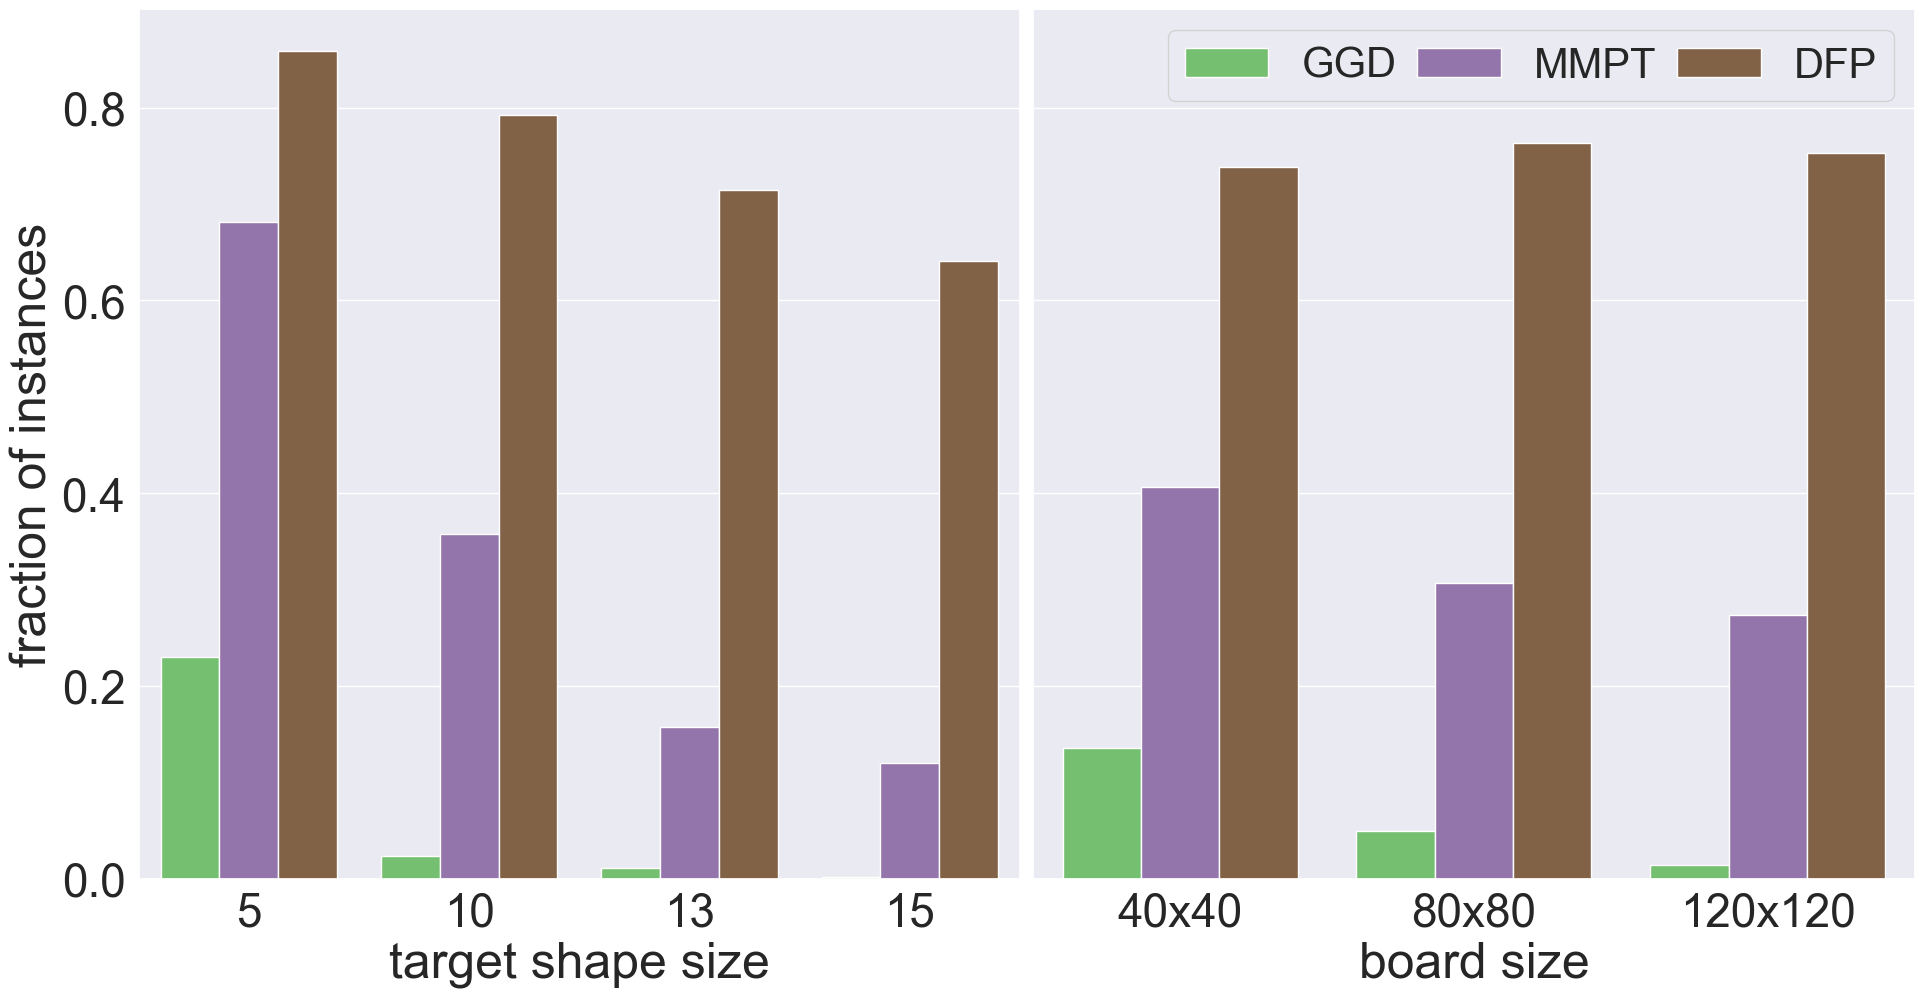

In [9]:
# performance comparison of multiple solvers on large instances
data = [all_i2[solver] for solver in ("GGD", "MMPT", "DFP")]
f1, f2 = plot_size_and_tiles_combined(data, y_axis="time", target_size_or_tiles="target_size")
f1.savefig("plots/i2_runtime.pdf", format="pdf", dpi=100)
f2.savefig("plots/i2_fraction_solved.pdf", format="pdf", dpi=100)

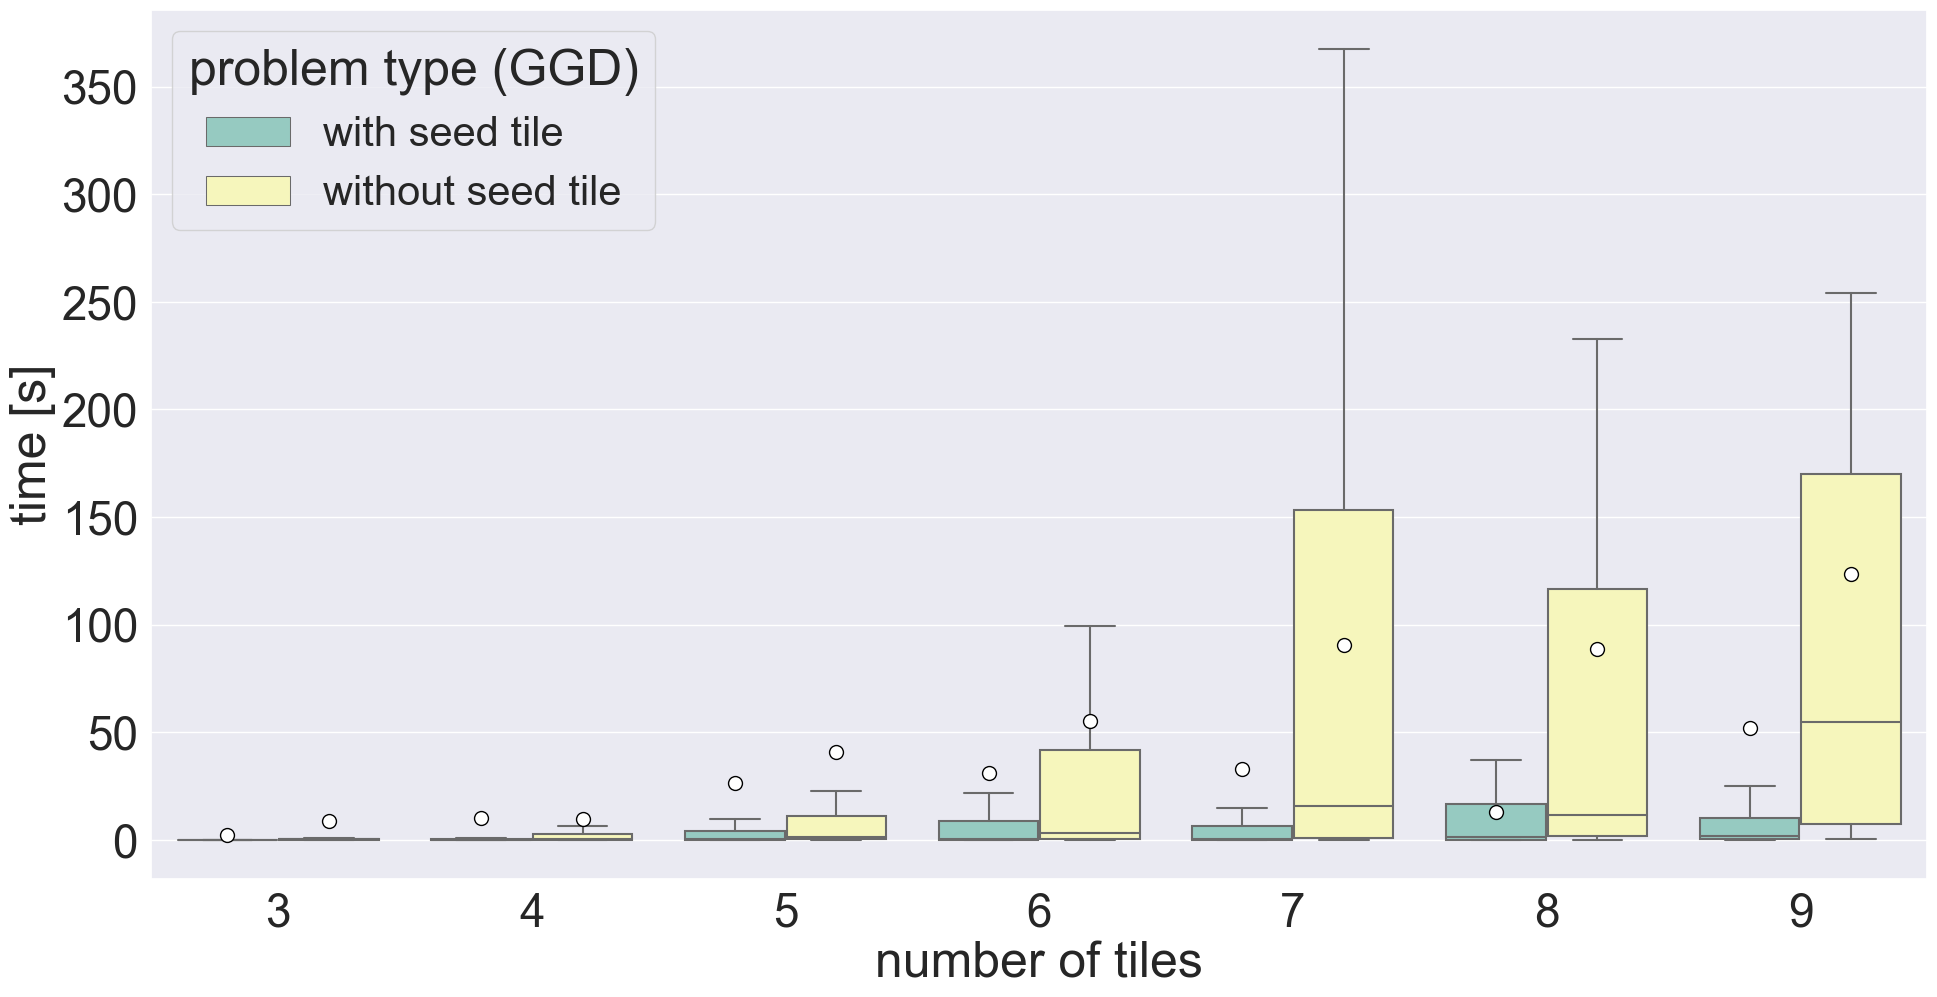

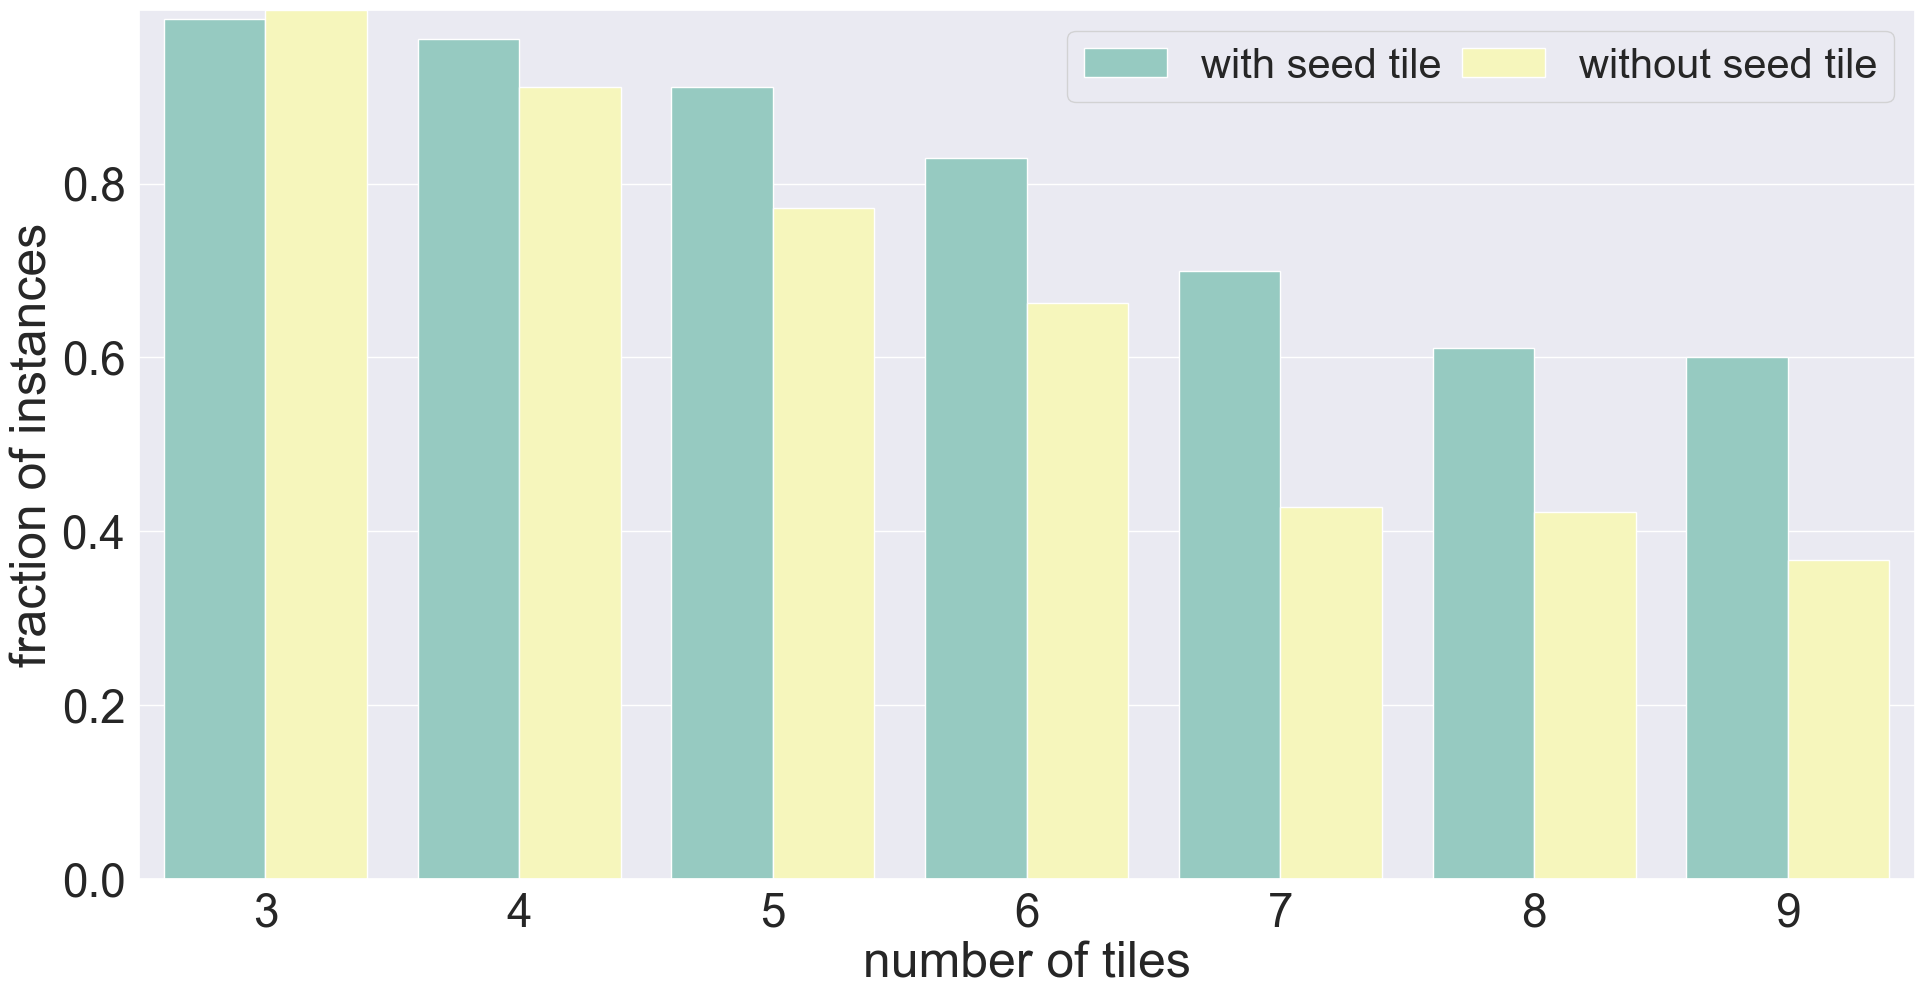

In [10]:
solver = "GGD"
data = all_i1[solver]
f1, f2 = plot_fixed_vs_not_fixed(data, solver, x_axis="tiles", y_axis="time")
f1.savefig("plots/fixed_vs_not_fixed.pdf", format="pdf", dpi=100)
f2.savefig("plots/fraction_solved_fixed_vs_not_fixed.pdf", format="pdf", dpi=100)

In [11]:
plt.close("all")